<a href="https://colab.research.google.com/github/anitamezzetti/financial_big_data/blob/main/granger_causality_many_cuntries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
student1 = "Anita Mezzetti"
student2 = "Hien Lê"

Complementary stuff:
* Drive Folder to save data, notebooks and models

Note: project has been linked to [Github](https://github.com/anitamezzetti/financial_big_data)!

In [2]:
from google.colab import drive
import os, sys

drive.mount('/content/drive')
#nb_path = '/content/notebooks2'
#os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
#sys.path.insert(0,nb_path)

#!pip install --target=$nb_path arrow

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls "/content/drive/My Drive/Colab Notebooks" # checking the content of the folder

 AnitaVersion_FinBigData_1.ipynb   generate_dataset_dataset4.ipynb
 CHE.csv			   generate_dataset_fixedK_movingS0.ipynb
 CHN.csv			   generate_dataset.ipynb
 classification_3.ipynb		   granger_causality_many_cuntries.ipynb
'classification_4 (1).ipynb'	  'Heston_Project (1).ipynb'
 classification_4.ipynb		  'Heston_Project (2).ipynb'
 classification.ipynb		   Heston_Project.ipynb
 closed_form_solution.ipynb	   JPN.csv
'complete_mc (1).ipynb'		   Untitled
'complete_mc (2).ipynb'		  'Untitled (1)'
 complete_mc.ipynb		   USA.csv
'Copia di mc.ipynb'


In [4]:
root = "/content/drive/My Drive/Colab Notebooks" 

In [5]:
!pip install arrow

In [6]:
!pip install ipynb

## Data

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import networkx as nx
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
import ipynb 

# other libraries here
import requests
import arrow

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Import functions for granger causality

In [8]:
from ipynb.fs.full.granger_causality_functions import make_stationary, grangers_causality_matrix, network_granger, granger_causality

In [9]:
# The following snippet gets data for the 4 countries from a proxy API, but it seems that the database in this API is not up-to-date
# jh_data = requests.get('https://covid19api.herokuapp.com/confirmed')

# res_dict = jh_data.json()["locations"]
# df_res = pd.json_normalize(res_dict)
# df_res = df_res.drop(columns=["country_code", "latest", "province", "coordinates.latitude", "coordinates.longitude"])

# countries_of_interest = ["US", "Switzerland", "Japan", "China"]

# df_china = df_res[df_res.country == "China"].set_index("country")
# df_china = pd.DataFrame(df_china.sum(axis=0), columns=["China"]).T

# df = df_res[df_res.country.isin(countries_of_interest[:3])].set_index("country")
# df = pd.concat([df, df_china])

In [10]:
countries_of_interest = ["USA", "CHE", "JPN", "CHN"]

endpoint = "https://covidapi.info/api/v1" # endpoint that provides JHU data
start_date = "2020-01-1"
end_date = "2020-12-01" # yesterday
dfs = {} # dfs of cumulative confirmed cases
for country in countries_of_interest:
  query = f"{endpoint}/country/{country}/timeseries/{start_date}/{end_date}"
  res = requests.get(query).json()
  df = pd.DataFrame(res["result"])
  df.index = pd.DatetimeIndex(df["date"], tz="utc")
  df.drop(columns=["date"])
  df["date"] = pd.to_datetime(df["date"])
  df["ts_in_secs"] = df["date"].astype(int)
  df["new_confirmed"] = df["confirmed"].diff().fillna(0)
  df.to_csv(f"{root}/{country}.csv")
  dfs[country] = df

## Analysis

In [11]:
# dataset for confirmed cases for each country (needed later)
df_confirmed = pd.DataFrame(index = dfs[country].index)
df_total = pd.DataFrame(index = dfs[country].index)

In [12]:
# first overview
for country,df in dfs.items():  
    df_confirmed[country] = df["new_confirmed"] 
    df_total[country] = df["confirmed"]

In [13]:
mid_period = ("2020-06-12", "2020-10-12")  # arbitrarily chosen, subject to change             
first_period = (start_date, mid_period[0]) # beginning of pandemic
last_period = (mid_period[1], arrow.get(end_date)) # most recent 

## Study New Cases

Normalize data

In [14]:

from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df_confirmed.values)
df_confirmed_scaled = pd.DataFrame(x_scaled)
df_confirmed_scaled = df_confirmed_scaled.rename(columns={
    0:countries_of_interest[0],
    1:countries_of_interest[1],
    2:countries_of_interest[2],
    3:countries_of_interest[3]
})
df_confirmed_scaled['Date'] = df_confirmed.index
df_confirmed_scaled = df_confirmed_scaled.set_index('Date')
df_confirmed_scaled.head()

,USA,CHE,JPN,CHN
Date,,,,
2020-01-22 00:00:00+00:00,0.000000,0.0,0.000000,0.000066
2020-01-23 00:00:00+00:00,0.000000,0.0,0.000000,0.006342
2020-01-24 00:00:00+00:00,0.000005,0.0,0.000000,0.018366
2020-01-25 00:00:00+00:00,0.000000,0.0,0.000000,0.032173
2020-01-26 00:00:00+00:00,0.000015,0.0,0.000747,0.044262


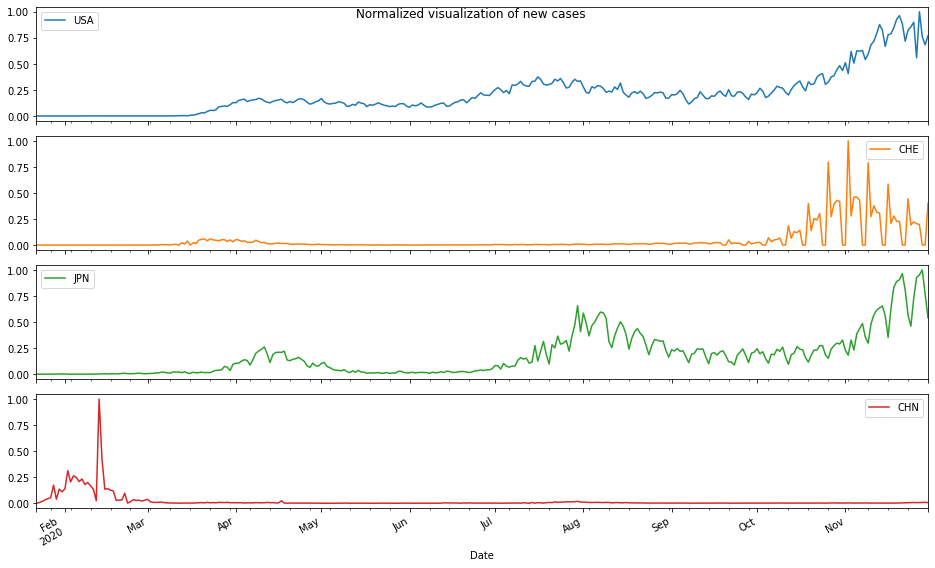

In [15]:
df_confirmed_scaled.plot(subplots=True, title='Normalized visualization of new cases', figsize=(13,8))
plt.tight_layout()
plt.show()

### Correlation matrix of new cases among different countries

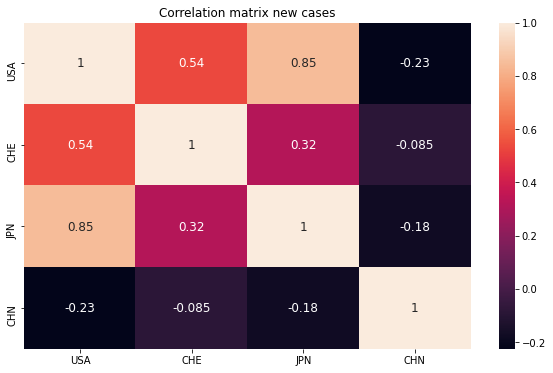

In [16]:
corr = df_confirmed_scaled.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True, annot_kws={'size':12})
heat_map = plt.gcf()
heat_map.set_size_inches(10,6)
plt.title('Correlation matrix new cases')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

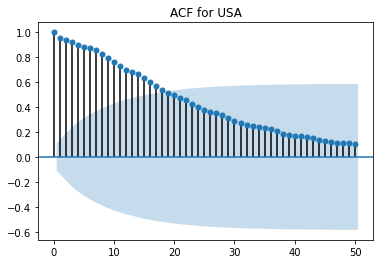

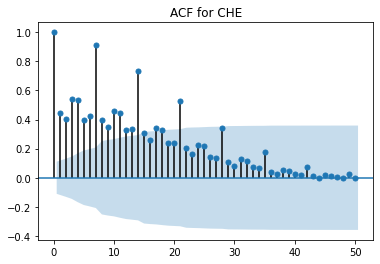

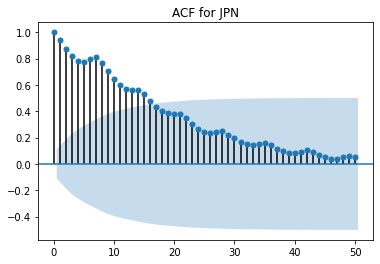

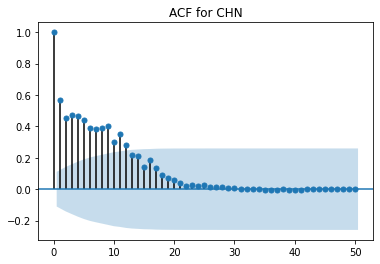

In [17]:
for country in df_confirmed_scaled:
    sm.graphics.tsa.plot_acf(df_confirmed_scaled[country], lags = 50)
    plt.title('ACF for %s' % country)
    plt.show()

STATIONARY TEST: 

 Dickey-Fuller Stationary Test for "USA" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -1.6141
 No. Lags Chosen      = 15
 Critical value 1%     = -3.452
 Critical value 5%     = -2.871
 Critical value 10%    = -2.572
 => P-Value = 0.4758. Weak evidence to reject H0.
 => Series in Non-Stationary


 Dickey-Fuller Stationary Test for "CHE" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -1.3911
 No. Lags Chosen      = 16
 Critical value 1%     = -3.453
 Critical value 5%     = -2.871
 Critical value 10%    = -2.572
 => P-Value = 0.5865. Weak evidence to reject H0.
 => Series in Non-Stationary


 Dickey-Fuller Stationary Test for "JPN" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics    

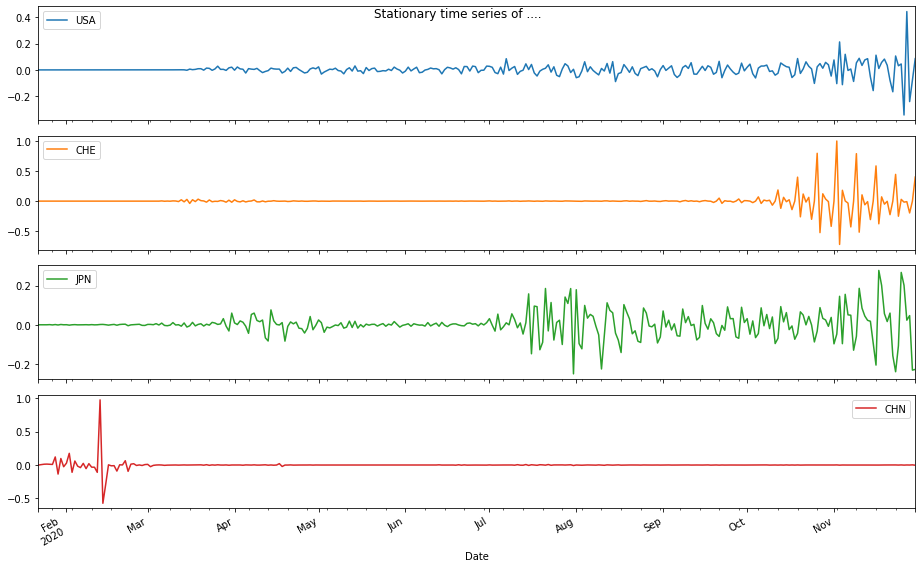


GRANGER CAUSALITY MATRIX: 



,USA_x,CHE_x,JPN_x,CHN_x
USA_y,0.000000,0.000000,0.000000,0.990800
CHE_y,0.000000,0.000000,0.000000,0.985500
JPN_y,0.000000,0.000000,0.000000,0.977900
CHN_y,0.995800,0.987500,0.986200,0.000000


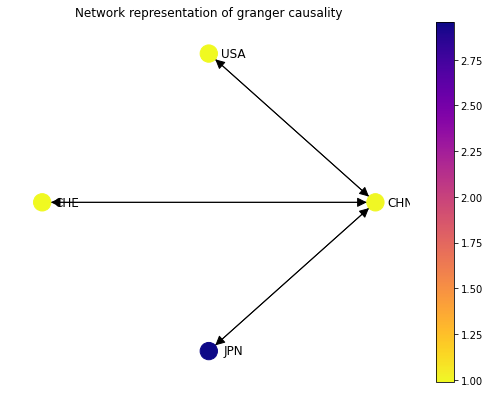

In [18]:
granger_causality(df_confirmed_scaled, countries_of_interest)

Functions for granger causality

## Study Total Cases

Normalize data

In [19]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df_total.values)
df_total_scaled = pd.DataFrame(x_scaled)
df_total_scaled = df_total_scaled.rename(columns={
    0:countries_of_interest[0],
    1:countries_of_interest[1],
    2:countries_of_interest[2],
    3:countries_of_interest[3]
})
df_total_scaled['Date'] = df_total.index
df_total_scaled = df_total_scaled.set_index('Date')
df_total_scaled.head()

,USA,CHE,JPN,CHN
Date,,,,
2020-01-22 00:00:00+00:00,0.000000e+00,0.0,0.000000,0.000000
2020-01-23 00:00:00+00:00,0.000000e+00,0.0,0.000000,0.001029
2020-01-24 00:00:00+00:00,7.353214e-08,0.0,0.000000,0.004028
2020-01-25 00:00:00+00:00,7.353214e-08,0.0,0.000000,0.009290
2020-01-26 00:00:00+00:00,2.941286e-07,0.0,0.000013,0.016534


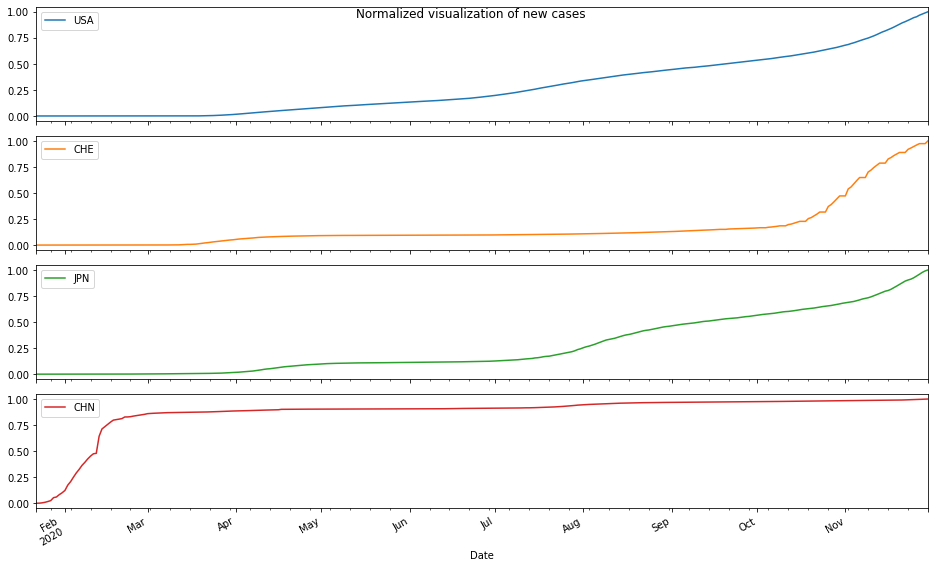

In [20]:
df_total_scaled.plot(subplots=True, title='Normalized visualization of new cases', figsize=(13,8))
plt.tight_layout()
plt.show()

### Correlation matrix of new cases among different countries

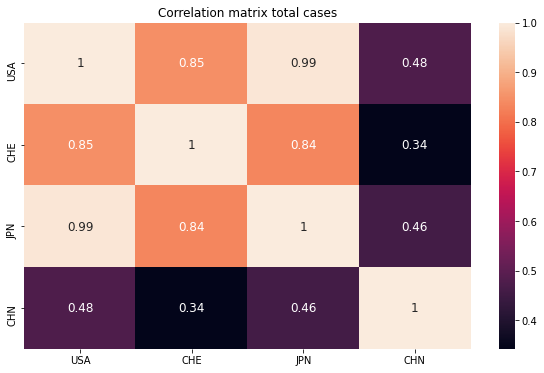

In [21]:
corr = df_total_scaled.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True, annot_kws={'size':12})
heat_map = plt.gcf()
heat_map.set_size_inches(10,6)
plt.title('Correlation matrix total cases')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [22]:
df_total_scaled.head()

,USA,CHE,JPN,CHN
Date,,,,
2020-01-22 00:00:00+00:00,0.000000e+00,0.0,0.000000,0.000000
2020-01-23 00:00:00+00:00,0.000000e+00,0.0,0.000000,0.001029
2020-01-24 00:00:00+00:00,7.353214e-08,0.0,0.000000,0.004028
2020-01-25 00:00:00+00:00,7.353214e-08,0.0,0.000000,0.009290
2020-01-26 00:00:00+00:00,2.941286e-07,0.0,0.000013,0.016534


### ACF function



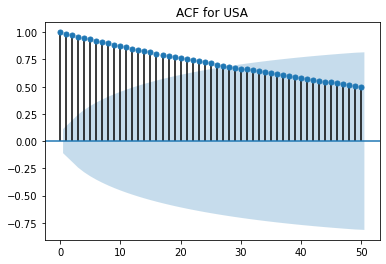

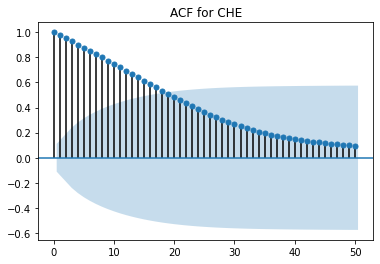

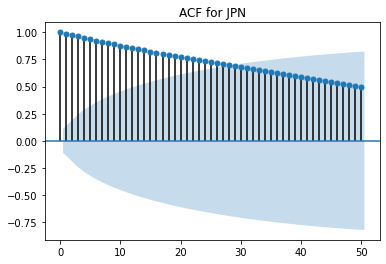

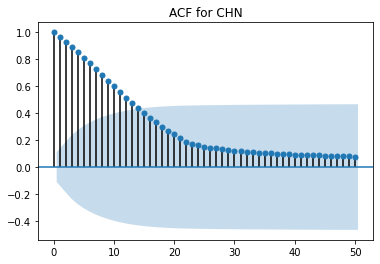

In [23]:
import statsmodels.api as sm

for country in df_confirmed_scaled:
    sm.graphics.tsa.plot_acf(df_total_scaled[country], lags = 50)
    plt.title('ACF for %s' % country)
    plt.show()

STATIONARY TEST: 

 Dickey-Fuller Stationary Test for "USA" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = 3.2176
 No. Lags Chosen      = 16
 Critical value 1%     = -3.453
 Critical value 5%     = -2.871
 Critical value 10%    = -2.572
 => P-Value = 1.0. Weak evidence to reject H0.
 => Series in Non-Stationary


 Dickey-Fuller Stationary Test for "CHE" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = 4.5934
 No. Lags Chosen      = 15
 Critical value 1%     = -3.452
 Critical value 5%     = -2.871
 Critical value 10%    = -2.572
 => P-Value = 1.0. Weak evidence to reject H0.
 => Series in Non-Stationary


 Dickey-Fuller Stationary Test for "JPN" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = 2.87

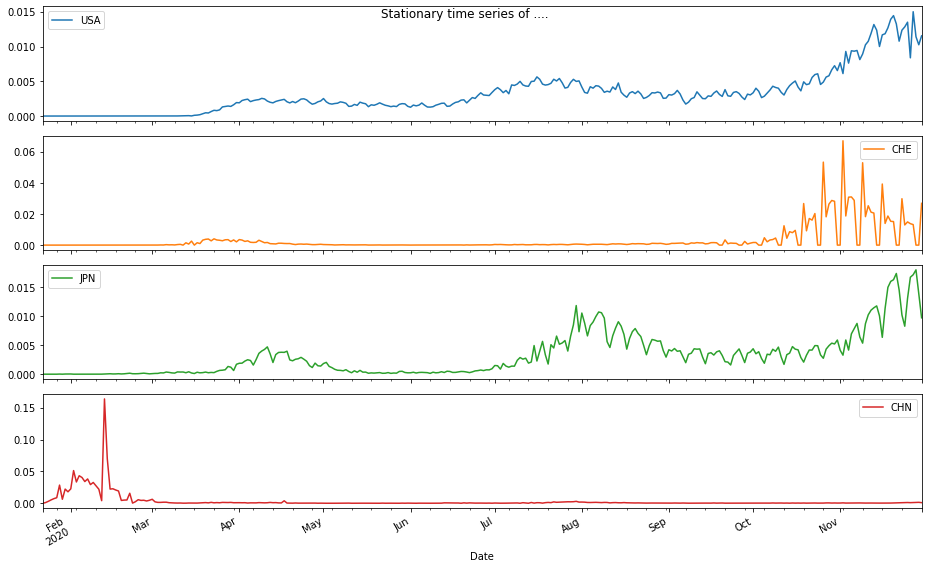


GRANGER CAUSALITY MATRIX: 



,USA_x,CHE_x,JPN_x,CHN_x
USA_y,0.000000,0.000000,0.000000,0.568000
CHE_y,0.000000,0.000000,0.000000,0.346900
JPN_y,0.000000,0.000000,0.000000,0.570400
CHN_y,0.029900,0.423400,0.090800,0.000000


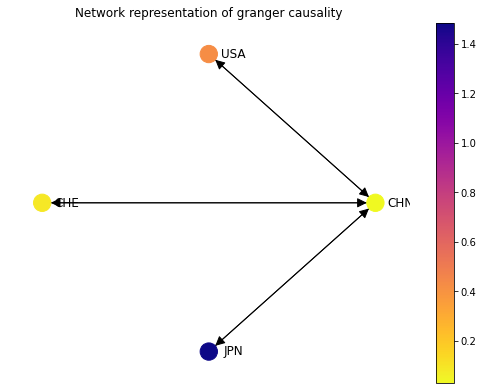

In [25]:
granger_causality(df_total_scaled, countries_of_interest)

 each value is highly correlated with the previous value

### Stationary test (Dickey-Fuller test)

https://github.com/KidQuant/Forecasting-VAR-Granger-Causality/blob/master/Forecasting-VAR-Granger-Causlity.ipynb
https://machinelearningmastery.com/time-series-data-stationary-python/


In [ ]:
# Perform DF test for Stationarity 
# return 0: stationary or 1: non-stationary
def dickey_fuller_test(series, country='', verbose=True):

    signif=0.05
    r = adfuller(series, autolag = 'AIC')
    output = {'test_statistics':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length=6): return str(val).ljust(length)

    print(f' Dickey-Fuller Stationary Test for "{country}"', "\n  ", '-'*47)
    # Print Summary
    if verbose==True:
        
        print(f' Null Hypothesis: Data are Non-Stationary.')
        print(f' Significance level   = {signif}')
        print(f' Test Statistics      = {output["test_statistics"]}')
        print(f' No. Lags Chosen      = {output["n_lags"]}')
          
        for key, val in r[4].items():
              print(f' Critical value {adjust(key)} = {round(val, 3)}')

          
    if p_value <= signif:
          print(f" => P-Value = {p_value}. Rejecting H0.")
          print(f" => Series is Stationary")
          return 0 # Stationary
    else:
          print(f" => P-Value = {p_value}. Weak evidence to reject H0.")
          print(f" => Series in Non-Stationary")
          return 1 # Non-Stationary


In [ ]:
stationary_test = {}
for country in df_confirmed_scaled:
    stat_country = dickey_fuller_test(df_confirmed_scaled[country], country)
    stationary_test[country] = stat_country
    print('\n')


Apart from CHN, all the other coutries are not stationary, so we need to make them stationary

### Stationary
In order to make the time series stationary, we need to apply a differencing function on the training set.

https://www.youtube.com/watch?v=bP1fbXd_XSk

In [ ]:
def make_stationary(df_confirmed_scaled, stationary_test):
    # save stationary time series:
    df_confirmed_stat = pd.DataFrame(index=df_confirmed_scaled.index)

    if sum(stationary_test.values())>0: # if at least one is not stationary

        for country in df_confirmed_scaled:
          df_confirmed_stat[country] = df_confirmed_scaled[country].diff()
          df_confirmed_stat[country][0] = 0

    else:
        df_confirmed_stat = df_confirmed_scaled
    
    return df_confirmed_stat

In [ ]:
# recheck stationarity after the diff
stationary_test = {}
for country in df_confirmed_stat:
    stat_country = dickey_fuller_test(df_confirmed_stat[country], country)
    stationary_test[country] = stat_country
    print('\n')

In [ ]:
if sum(stationary_test.values())>0:
  print("Error: all countries should be stationary")

Now they are all stationary. This could be reached also using rolling. Now we plot again this edited time series (it is always really sueful to have a visual idea)

In [ ]:
title = 'Stationary time series of ' + '....'
df_confirmed_stat.plot(subplots=True, title=title, figsize=(13,8))
plt.tight_layout()
plt.show()

Now that everything is stationary, we can prove granger causality

### Granger Causality test
https://medium.com/swlh/using-granger-causality-test-to-know-if-one-time-series-is-impacting-in-predicting-another-6285b9fd2d1c

the past values of time series (x) do not cause the other series (y). So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis. This has been performed on original data-set.

In [ ]:
maxlag=12
test = 'ssr-chi2test'

from statsmodels.tsa.stattools import grangercausalitytests

def grangers_causality_matrix(data, variables, test = 'ssr_chi2test', verbose=False):

    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)

    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(data[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')

            min_p_value = np.min(p_values)
            if r==c:
              dataset.loc[r,c] = 0 # one country is not correlated to itself
            else:
              dataset.loc[r,c] = min_p_value

    dataset.columns = [var + '_x' for var in variables]

    dataset.index = [var + '_y' for var in variables]


    return dataset


In [ ]:
# function which create sthe network and plots it

def network_granger(granger_matrix):

  a = granger_matrix.to_numpy() #adjuant matrix
  G = nx.DiGraph()

  non_zero_el = np.nonzero(a)

  for i in range(len(non_zero_el[0])):
      position = (non_zero_el[1][i], non_zero_el[0][i]) # position 1,0 because influence is from x(column) to y(row) according to the granger_matrix
      G.add_edges_from([position], weight=a[position[1], position[0]])

  #plot
  pos = nx.circular_layout(G)
  cmap = 'plasma_r'

  # set countries names as labels
  mapping = {}
  for i in range(len(countries_of_interest)):
    mapping[i] = countries_of_interest[i]
  labels = mapping

  # sum of all influences for each country
  country_importance = []
  for country in countries_of_interest:
    name = country + '_x'
    country_importance.append(granger_matrix[name].sum())

  plt.figure(figsize=(7,5))
  nx.draw(G, pos=pos, node_color=country_importance, cmap=cmap, edge_color='white')
  nx.draw_networkx_edges(G, pos=pos, arrowsize=20)
  for p in pos:  # raise text positions
      pos[p][0] += 0.15
  nx.draw_networkx_labels(G, pos, labels=labels)
  sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = min(country_importance), vmax=max(country_importance)))
  sm._A = []
  plt.title("Network representation of granger causality")
  plt.colorbar(sm)
  plt.show()


In [ ]:
def granger_causality(df):
    # check stationary:
    print("STATIONARY TEST: \n")
    stationary_test = {}
    for country in df:
        stat_country = dickey_fuller_test(df[country], country)
        stationary_test[country] = stat_country
        print('\n')

    # make them stationary:
    df_confirmed_stat = make_stationary(df, stationary_test)

    # recheck stationary:
    print("STATIONARY TEST after we make series stationary: \n")
    stationary_test = {}
    for country in df_confirmed_stat:
        stat_country = dickey_fuller_test(df_confirmed_stat[country], country, verbose=False)
        stationary_test[country] = stat_country
        print('\n')

    # print if something did not work
    if sum(stationary_test.values())>0:
      print("Error: all countries should be stationary")

    # print stationary series
    title = 'Stationary time series of ' + '....'
    df_confirmed_stat.plot(subplots=True, title=title, figsize=(13,8))
    plt.tight_layout()
    plt.show()

    # calculate granger matrix
    print("\nGRANGER CAUSALITY MATRIX: \n")
    granger_matrix = grangers_causality_matrix(df_confirmed_stat, countries_of_interest)
    display(granger_matrix.style.applymap(lambda x: "background-color: yellow" if x>0 else "background-color: white"))

    # plot network
    print("\n\n")
    network_granger(granger_matrix)


In [ ]:
granger_causality(df_confirmed_scaled)